## Interactive notebook for Co hydroformylation run example

nx_reaxgraf and nx_gTOFfee modules should be either installed or in the same folder as the notebook

Depends on input files `co_nodes.txt` and `co_edges.txt`

In [1]:
#Dependencies
import numpy as np
import networkx as nx
import nx_reaxgraf as rg
import nx_gTOFfee as gtof
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
#A couple of helper functions

def graph_skeleton_plot(graphD,pos,ax_draw,cmap_obj):
    '''
    Basic graph plotting without initialization of a new figure, for
    embedding in a subplot structure
    Input:
    graphD: a Graph object
    pos: positioning for the graph
    ax_draw: Axes object in which to draw the graph
    cmap_obj: Matplotlib colormap
    '''
    energy_dict=rg.nx.get_node_attributes(graphD,'energy')
    e_map=[item[1] for item in energy_dict.items()]
    rg.nx.draw(graphD,pos,ax=ax_draw,with_labels=False,node_size=100,
                node_color=e_map,cmap=cmap_obj,alpha=1.0,font_weight='bold')
    return None

def tof_joiner(tof_list,route_indices,temp):
    '''
    From a list of TOFs corresponding to two different products,
    join according to the formed product and return the eff. energy spans
    Input:
    tof_list. List of TOF values for all mechanisms.
    route_indices. List of two lists, each one containing all mech. indices corresponding to one or other product.
    temp. Float, temperature in Kelvin.
    Output:
    dE_1,dE_2. Floats: eff. energy spans for products 1 and 2
    '''
    tofs1=np.array(tof_list)[route_indices[0]]
    tofs2=np.array(tof_list)[route_indices[1]]
    dE_1=gtof.eff_E_span_calc(np.sum(tofs1),temp)
    dE_2=gtof.eff_E_span_calc(np.sum(tofs2),temp)
    return dE_1,dE_2
    

<IPython.core.display.Javascript object>


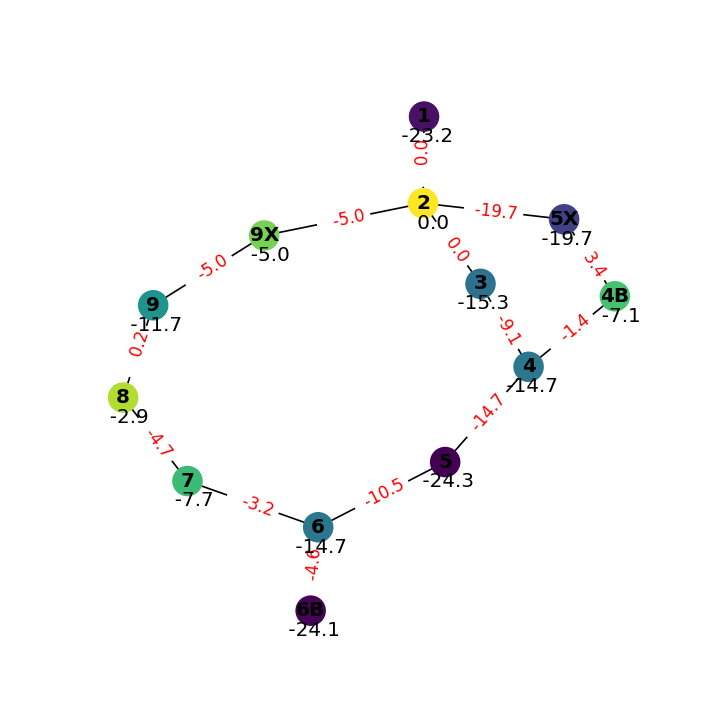

2 cycles in the main network
14 combinations will be tested
12 mechanisms have been accepted


In [10]:
#File reading & graph preparation
###PARAMETERS
temp=423

###Initialize the graph and plot it
G=rg.graph_instantiator("co_nodes.txt","co_edges.txt",closing_edges=["9X_2","5X_2"])
rg.plot_directed_network(G,parent_layout=False)
plt.show()

###Mechanism search 
mechanisms=rg.mechanism_fetcher(G)


In [11]:
#Calculation of TOF without concentration effects
A_nc,B_nc,*_=gtof.TOF_wrapper(mechanisms,temp,use_conc=False,verbose=False)
###TOF data processing
#Assignation of alkane-producing and aldehyde-producing routes from mechanisms
hydroform=[]
hydrogen=[]
routes=[hydroform,hydrogen]
for im,m in enumerate(mechanisms.MechList):
    closer=m.graph['ClosingEdge']
    if (closer == ('5X','2')):
        hydrogen.append(im)
    else:
        hydroform.append(im)

#Output
dE_hydroform_nc,dE_hydrogen_nc=tof_joiner(A_nc,[hydroform,hydrogen],temp)
print("|Aldehyde|%6.2f kcal/mol|" % dE_hydroform_nc)
print("|Alkane|%6.2f kcal/mol|" % dE_hydrogen_nc)



|Aldehyde| 25.22 kcal/mol|
|Alkane| 27.92 kcal/mol|


<IPython.core.display.Javascript object>


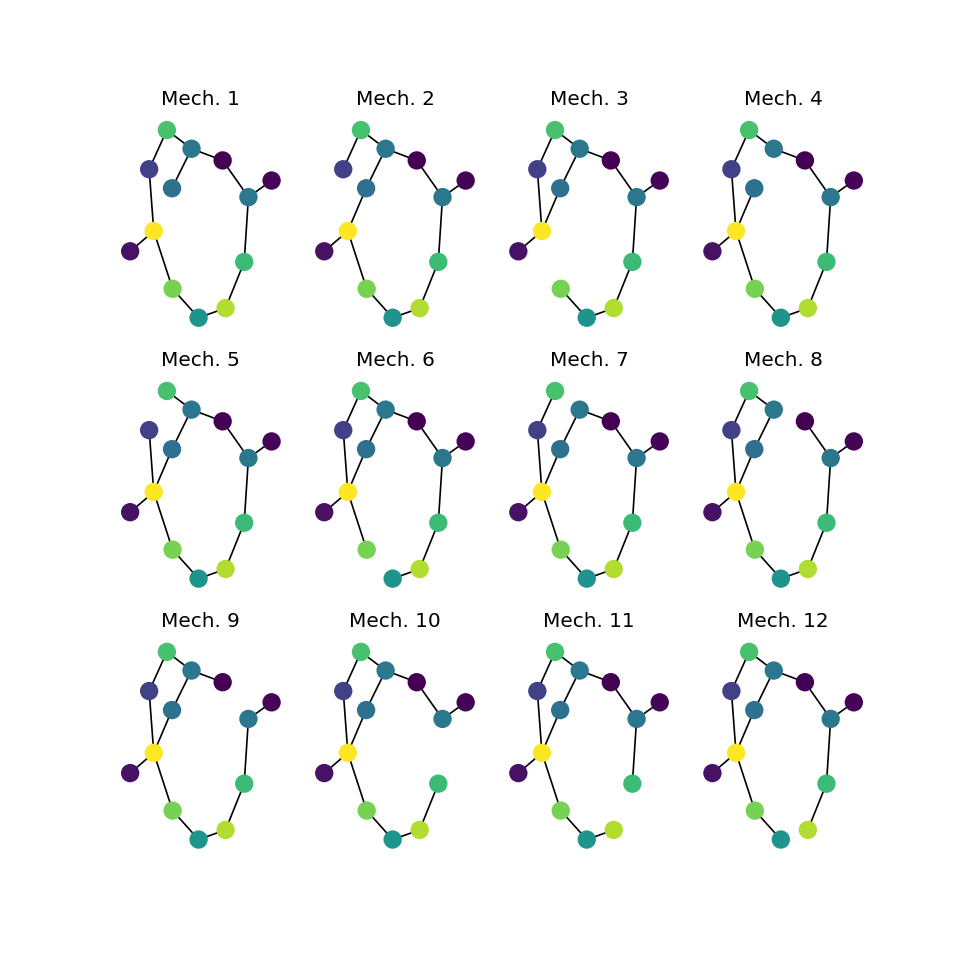

In [12]:
#Individual mechanism representation
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(8,8))
ax=axes.flatten()
#find the position for the main graph obj. and the colormap
posx=nx.spring_layout(mechanisms.MainGraph,k=0.5,iterations=200)
viridis_map=plt.cm.viridis
for im,mx in enumerate(mechanisms.MechList):
    graph_skeleton_plot(mx,posx,ax[im],viridis_map)
    ax[im].set_title("Mech. %d" % (im+1))
plt.show()

We have 12 mechanisms blablabla

<IPython.core.display.Javascript object>


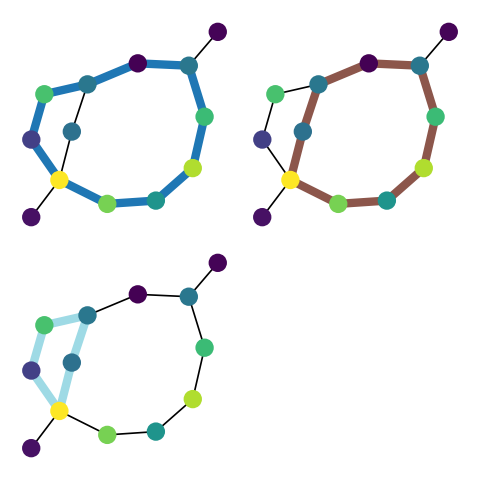

(<Figure size 400x400 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b9d09be48>,
       dtype=object))

In [7]:
#Mechanism type representation
mech_kinds_dummies,mech_kinds_cyclist=rg.mech_judge(mechanisms)
rg.mech_typology_plot(mechanisms,mech_kinds_cyclist)

In [14]:
###Results with concentrations
c_low={"CO":0.8,"H2":0.8,"ALK":0.5,"PR1":0.01,"PR2":0.01,"x":None}
c_high={"CO":1.5,"H2":1.0,"ALK":2.0,"PR1":0.01,"PR2":0.01,"x":None}

A_low,B_low,*_=gtof.TOF_wrapper(mechanisms,temp,use_conc=True,dict_conc=c_low,verbose=False)
A_high,B_high,*_=gtof.TOF_wrapper(mechanisms,temp,use_conc=True,dict_conc=c_high,verbose=False)

dE_hydroform_low,dE_hydrogen_low=tof_joiner(A_low,[hydroform,hydrogen],temp)
dE_hydroform_high,dE_hydrogen_high=tof_joiner(A_high,[hydroform,hydrogen],temp)


print("|%12s|%8s|%8s|" % ("Product","clow","chigh"))
print("|%12s|%8.2f|%8.2f|" % ("Aldehyde",dE_hydroform_low,dE_hydroform_high))
print("|%12s|%8.2f|%8.2f|" % ("Alkane",dE_hydrogen_low,dE_hydrogen_high))


|     Product|    clow|   chigh|
|    Aldehyde|   25.63|   24.90|
|      Alkane|   27.00|   27.92|


======================== Iteration 0 ========================
======================== Iteration 25 ========================
======================== Iteration 50 ========================
======================== Iteration 75 ========================
======================== Iteration 100 ========================
======================== Iteration 125 ========================
======================== Iteration 150 ========================
======================== Iteration 175 ========================
======================== Iteration 200 ========================
======================== Iteration 225 ========================
======================== Iteration 250 ========================
======================== Iteration 275 ========================
======================== Iteration 300 ========================
======================== Iteration 325 ========================
======================== Iteration 350 ========================
======================== Iteration 375 ======

<IPython.core.display.Javascript object>


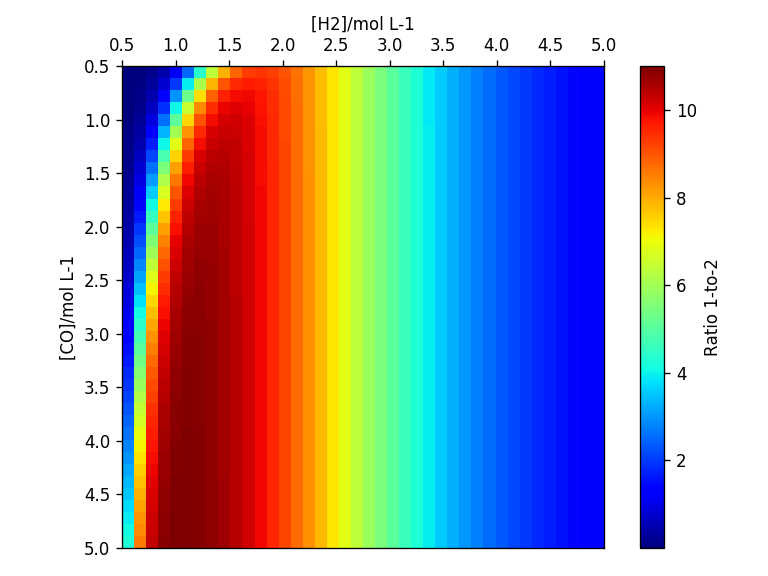

In [17]:
#2D Selectivity map run
#Modify [CO] and [H2]
cREF={"CO":0,"H2":0,"ALK":3.0,"PR1":0.25,"PR2":0.25,"x":None}
Ctestvals=[["CO",0.5,5.0,40],["H2",0.5,5.0,40]]
#Build the array of concentrations
Carray=gtof.conc_iterator_2D(Ctestvals)
#Use pre-built mechanisms and trees with pre_init_model = True
Rarray=gtof.TOF_conc_test(mechanisms,temp,Carr=Carray,list_entries=Ctestvals,
                        processes=[hydroform,hydrogen],template_dict=cREF,
                        pre_init_model=True)
fig,ax=gtof.plot_matrix_quotient(Rarray,Ctestvals)
plt.tight_layout()
plt.show()

